In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# # new file
# from rules import preprocess_texts, custom_loss, augment_features


In [2]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
# model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=24)  # adjust num_labels as necessary
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=7)  # for no_bibles version


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [4]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers

In [5]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    for dialect, directory_path in directory_paths.items():
        print("dialect: ", dialect)
        for filename in os.listdir(directory_path):
            print("filename: ", filename)
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read().strip()
                text = remove_numbers(text)
                

                # Split document into chunks
                chunks = split_document(text)
                print("document is in ", len(chunks), " chunks")

                # Process each chunk
                for chunk in chunks:
                    # Convert tokens to ids, skipped as tokenizer will handle it
                    # chunk_ids = tokenizer.convert_tokens_to_ids(chunk)
                    
                    # Tokenize text and include attention mask
                    encoded_text = tokenizer(chunk, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
                    # Ensure conversion to list of integers
                    input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                    attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                    processed_data.append({
                        'input_ids': input_ids_list,
                        'attention_mask': attention_mask_list,
                        'labels': label_dict[dialect]
                    })
    return processed_data


In [6]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [7]:
# no bibles version

directory_paths_no_bibles = {
    # 'other': '../language_resources/dialects_no_bible/other_quechua/',
    'quh': '../language_resources/dialects_no_bible/quh',
    'quk': '../language_resources/dialects_no_bible/quk',
    'qux': '../language_resources/dialects_no_bible/qux',
    'quy': '../language_resources/dialects_no_bible/quy',
    'quz': '../language_resources/dialects_no_bible/quz', 
    'qwh': '../language_resources/dialects_no_bible/qwh',
    'qxo': '../language_resources/dialects_no_bible/qxo'
    # 'southern': '../language_resources/dialects_no_bible/southern_quechua'
}

processed_data = load_and_preprocess(directory_paths_no_bibles)

dialect:  quh
filename:  MUL028R071I001.txt
document is in  6  chunks
filename:  MUL028R109I001.txt
document is in  6  chunks
filename:  MUL028R061I001.txt
document is in  6  chunks
filename:  MUL028R095I001.txt
document is in  6  chunks
filename:  MUL028R085I001.txt
document is in  10  chunks
filename:  ailla_story_bolivian.txt
document is in  52  chunks
filename:  MUL028R068I001.txt
document is in  6  chunks
filename:  MUL028R110I001.txt
document is in  6  chunks
filename:  MUL028R078I001.txt
document is in  4  chunks
filename:  MUL028R100I001.txt
document is in  6  chunks
filename:  MUL028R101I001.txt
document is in  6  chunks
filename:  MUL028R079I001.txt
document is in  6  chunks
filename:  MUL028R069I001.txt
document is in  6  chunks
filename:  .DS_Store
document is in  1  chunks
filename:  interview_rufina1.txt
document is in  43  chunks
filename:  MUL028R060I001.txt
document is in  7  chunks
filename:  MUL028R108I001.txt
document is in  6  chunks
filename:  interview_cirrilio3.

In [8]:
# create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})

# set dataset format for pytorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [9]:
print(len(processed_data))

4707


In [10]:
# Split the dataset
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

In [11]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)


In [29]:
# List to store accuracy per epoch
epoch_accuracy = []
true_labels = []
predicted_labels = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    # Extend the global lists
    true_labels.extend(labels.tolist())
    predicted_labels.extend(preds.tolist())

    # make confusion matrix work
    # true_labels.extend(labels_list)
    # predicted_labels.extend(preds_list)
    
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [30]:
from transformers import get_scheduler

In [31]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Increased epochs
    per_device_train_batch_size=10,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy",
    report_to="tensorboard"  # Ensure metrics are reported to TensorBoard
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

{'loss': 0.1047, 'grad_norm': 0.7631085515022278, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}
{'loss': 0.1227, 'grad_norm': 7.938599109649658, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.05}
{'loss': 0.1309, 'grad_norm': 0.19609659910202026, 'learning_rate': 3e-06, 'epoch': 0.07}
{'loss': 0.0984, 'grad_norm': 2.075758457183838, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.1}
{'loss': 0.0696, 'grad_norm': 6.7025651931762695, 'learning_rate': 5e-06, 'epoch': 0.12}
{'loss': 0.0418, 'grad_norm': 0.9446854591369629, 'learning_rate': 6e-06, 'epoch': 0.15}
{'loss': 0.0514, 'grad_norm': 0.034606240689754486, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.17}
{'loss': 0.0411, 'grad_norm': 1.1455045938491821, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.2}
{'loss': 0.0213, 'grad_norm': 0.013469790108501911, 'learning_rate': 9e-06, 'epoch': 0.23}
{'loss': 0.0435, 'grad_norm': 5.601475238800049, 'learning_rate': 1e-05, 'epoch': 0.25}
{'loss': 0.099, 'grad_norm':

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.22700828313827515, 'eval_accuracy': 0.9462517680339463, 'eval_f1': 0.9432146652986848, 'eval_precision': 0.948340860740271, 'eval_recall': 0.9462517680339463, 'eval_runtime': 15.945, 'eval_samples_per_second': 44.34, 'eval_steps_per_second': 3.01, 'epoch': 1.0}
{'loss': 0.0643, 'grad_norm': 0.4736498296260834, 'learning_rate': 4.1e-05, 'epoch': 1.02}
{'loss': 0.1455, 'grad_norm': 10.240158081054688, 'learning_rate': 4.2e-05, 'epoch': 1.05}
{'loss': 0.0341, 'grad_norm': 0.19409701228141785, 'learning_rate': 4.3e-05, 'epoch': 1.07}
{'loss': 0.0643, 'grad_norm': 0.16461914777755737, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.1}
{'loss': 0.1857, 'grad_norm': 19.289127349853516, 'learning_rate': 4.5e-05, 'epoch': 1.12}
{'loss': 0.1074, 'grad_norm': 8.292496681213379, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.15}
{'loss': 0.1143, 'grad_norm': 1.576480746269226, 'learning_rate': 4.7e-05, 'epoch': 1.18}
{'loss': 0.0452, 'grad_norm': 0.01587943732738495, 'learn

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.16011972725391388, 'eval_accuracy': 0.9731258840169731, 'eval_f1': 0.973315423960935, 'eval_precision': 0.9763573468101224, 'eval_recall': 0.9731258840169731, 'eval_runtime': 21.4997, 'eval_samples_per_second': 32.884, 'eval_steps_per_second': 2.233, 'epoch': 2.0}
{'loss': 0.064, 'grad_norm': 0.04625403508543968, 'learning_rate': 4.491324795060491e-05, 'epoch': 2.02}
{'loss': 0.1954, 'grad_norm': 10.50387954711914, 'learning_rate': 4.4592336433146e-05, 'epoch': 2.05}
{'loss': 0.1014, 'grad_norm': 2.4677059650421143, 'learning_rate': 4.426283106939474e-05, 'epoch': 2.08}
{'loss': 0.0821, 'grad_norm': 0.16505852341651917, 'learning_rate': 4.3924876391293915e-05, 'epoch': 2.1}
{'loss': 0.1388, 'grad_norm': 0.020275911316275597, 'learning_rate': 4.357862063693486e-05, 'epoch': 2.12}
{'loss': 0.2719, 'grad_norm': 73.59675598144531, 'learning_rate': 4.3224215685535294e-05, 'epoch': 2.15}
{'loss': 0.0512, 'grad_norm': 0.00566680496558547, 'learning_rate': 4.2861816990820084e-0

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.0879143476486206, 'eval_accuracy': 0.9745403111739745, 'eval_f1': 0.9747287853214827, 'eval_precision': 0.9768464978421922, 'eval_recall': 0.9745403111739745, 'eval_runtime': 15.5371, 'eval_samples_per_second': 45.504, 'eval_steps_per_second': 3.089, 'epoch': 3.0}
{'loss': 0.0366, 'grad_norm': 0.0039030874613672495, 'learning_rate': 2.7091946083307896e-05, 'epoch': 3.02}
{'loss': 0.0209, 'grad_norm': 0.006703938357532024, 'learning_rate': 2.656976298823284e-05, 'epoch': 3.05}
{'loss': 0.047, 'grad_norm': 0.005859460681676865, 'learning_rate': 2.604689134322999e-05, 'epoch': 3.08}
{'loss': 0.0154, 'grad_norm': 0.003637392306700349, 'learning_rate': 2.5523560497083926e-05, 'epoch': 3.1}
{'loss': 0.024, 'grad_norm': 0.0028369673527777195, 'learning_rate': 2.5e-05, 'epoch': 3.12}
{'loss': 0.0275, 'grad_norm': 0.014311966486275196, 'learning_rate': 2.447643950291608e-05, 'epoch': 3.15}
{'loss': 0.0669, 'grad_norm': 1.2290983200073242, 'learning_rate': 2.3953108656770016e-05,

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.08978597074747086, 'eval_accuracy': 0.9632248939179632, 'eval_f1': 0.9623184788875603, 'eval_precision': 0.9670654468684025, 'eval_recall': 0.9632248939179632, 'eval_runtime': 15.6157, 'eval_samples_per_second': 45.275, 'eval_steps_per_second': 3.074, 'epoch': 4.0}
{'loss': 0.0522, 'grad_norm': 0.005523968022316694, 'learning_rate': 7.886322351782783e-06, 'epoch': 4.03}
{'loss': 0.0457, 'grad_norm': 0.004184361547231674, 'learning_rate': 7.508416487165862e-06, 'epoch': 4.05}
{'loss': 0.0206, 'grad_norm': 0.0021028132177889347, 'learning_rate': 7.138183009179922e-06, 'epoch': 4.08}
{'loss': 0.0421, 'grad_norm': 4.378044605255127, 'learning_rate': 6.775784314464717e-06, 'epoch': 4.1}
{'loss': 0.0213, 'grad_norm': 0.004777492024004459, 'learning_rate': 6.421379363065142e-06, 'epoch': 4.12}
{'loss': 0.0485, 'grad_norm': 1.9624463319778442, 'learning_rate': 6.075123608706093e-06, 'epoch': 4.15}
{'loss': 0.0402, 'grad_norm': 0.003250404726713896, 'learning_rate': 5.7371689306

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.09139234572649002, 'eval_accuracy': 0.9603960396039604, 'eval_f1': 0.9596124738524274, 'eval_precision': 0.9648665475066777, 'eval_recall': 0.9603960396039604, 'eval_runtime': 15.7369, 'eval_samples_per_second': 44.926, 'eval_steps_per_second': 3.05, 'epoch': 5.0}
{'train_runtime': 1810.655, 'train_samples_per_second': 11.046, 'train_steps_per_second': 1.105, 'train_loss': 0.078340264396742, 'epoch': 5.0}


TrainOutput(global_step=2000, training_loss=0.078340264396742, metrics={'train_runtime': 1810.655, 'train_samples_per_second': 11.046, 'train_steps_per_second': 1.105, 'total_flos': 2649584209920000.0, 'train_loss': 0.078340264396742, 'epoch': 5.0})

  0%|          | 0/48 [00:00<?, ?it/s]

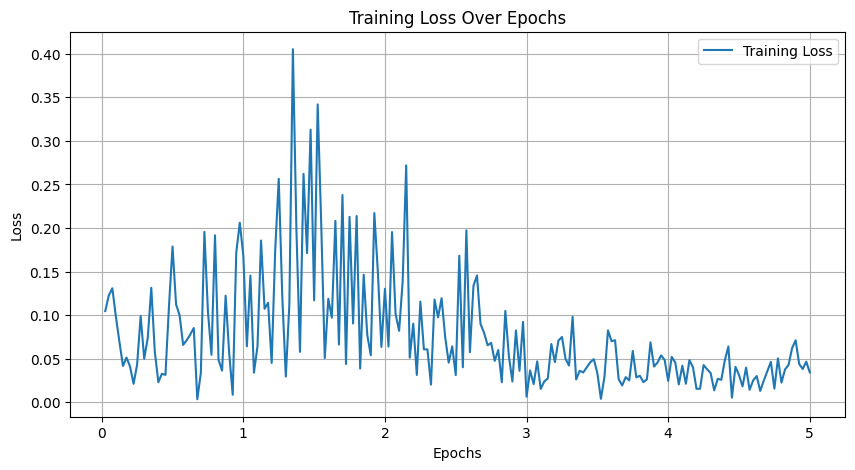

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

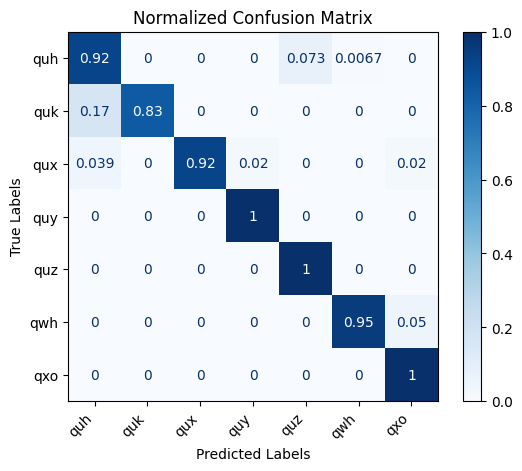

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(trainer):
    # Get predictions
    predictions, labels, _ = trainer.predict(val_dataset)
    preds_flat = predictions.argmax(-1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds_flat, normalize='true')

    # Extract unique labels (sorted by value) to ensure consistent label names
    unique_labels = np.unique(np.concatenate((labels, preds_flat)))
    label_names = [list(directory_paths_no_bibles.keys())[label] for label in unique_labels]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=45, ha="right")  # Optional: Rotate labels for better visibility
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(trainer)



confusion matrix no normalization

  0%|          | 0/48 [00:00<?, ?it/s]

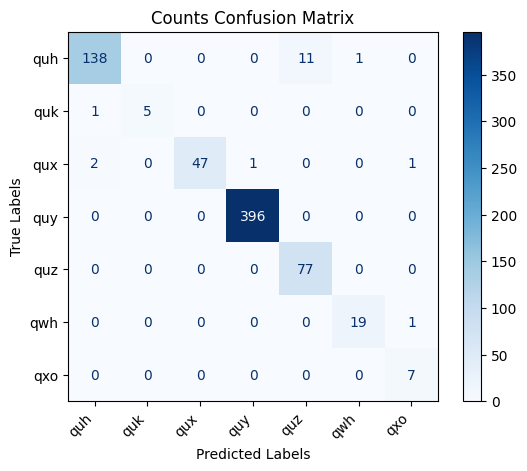

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(trainer):
    # Get predictions
    predictions, labels, _ = trainer.predict(val_dataset)
    preds_flat = predictions.argmax(-1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds_flat)

    # Extract unique labels (sorted by value) to ensure consistent label names
    unique_labels = np.unique(np.concatenate((labels, preds_flat)))
    label_names = [list(directory_paths_no_bibles.keys())[label] for label in unique_labels]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Counts Confusion Matrix')
    plt.xticks(rotation=45, ha="right")  # Optional: Rotate labels for better visibility
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(trainer)



In [48]:
true_labels = []
predicted_labels = []

for data in Dataloader:  # Assuming dataloader is properly set up
    inputs, labels = data['inputs'], data['labels']
    outputs = model(inputs)
    preds = outputs.argmax(dim=1)
    
    true_labels.extend(labels.tolist())
    predicted_labels.extend(preds.tolist())

NameError: name 'dataloader' is not defined

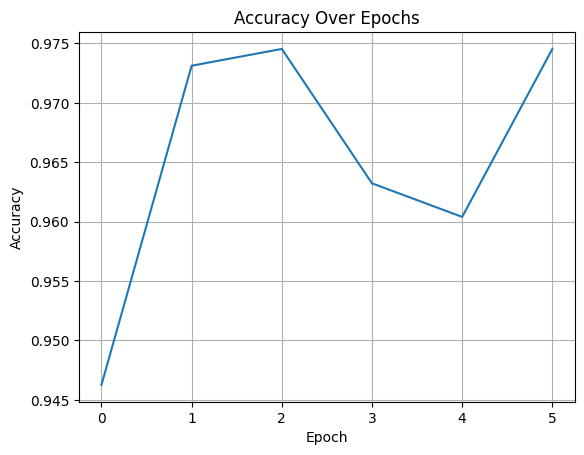

In [35]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

In [36]:
def get_predictions(model, dataloader):
    model.eval()  # Put model in evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels

In [37]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths_no_bibles.keys()])
print("Classification Report:\n", report)

/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_61165/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_61165/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         quh       0.98      0.92      0.95       150
         quk       1.00      0.83      0.91         6
         qux       1.00      0.92      0.96        51
         quy       1.00      1.00      1.00       396
         quz       0.88      1.00      0.93        77
         qwh       0.95      0.95      0.95        20
         qxo       0.78      1.00      0.88         7

    accuracy                           0.97       707
   macro avg       0.94      0.95      0.94       707
weighted avg       0.98      0.97      0.97       707



In [25]:
unlabeled = {
    'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}
unlabeled_processed = load_and_preprocess(unlabeled)

label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}


dialect:  other
filename:  .DS_Store
document is in  1  chunks
filename:  qu.txt
document is in  4487  chunks
dialect:  southern
filename:  cosude2009-2011.txt
document is in  33  chunks
filename:  amerindia_1999.txt
document is in  49  chunks
filename:  wikimedia.txt
document is in  21  chunks
filename:  cc100-quechua.txt
document is in  4487  chunks
filename:  gregorio_condori_mamani.txt
document is in  23  chunks
filename:  Lectura-favorita-quechua-cusco-2019.txt
document is in  19  chunks
filename:  normatividad_ana_2013.txt
document is in  117  chunks
filename:  microsoft_2021.txt
document is in  13  chunks
filename:  lecturas-favoritas-quechua-chanka-2019.txt
document is in  19  chunks
filename:  focus_2007.txt
document is in  14  chunks
filename:  poder_jucial_peru.txt
document is in  15  chunks
filename:  acuerdo_nacional_2014.txt
document is in  49  chunks
filename:  unesco_2020.txt
document is in  76  chunks
filename:  tatoeba.txt
document is in  7  chunks
filename:  que_comm

In [26]:
# try to do stuff with unloaded data

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)  # Move model to the appropriate device

def predict(model, dataset):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device

    for item in dataset:
        # Extract tensors and move them to the correct device
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = torch.argmax(outputs.logits, dim=-1)
            predictions.append(prediction.item())

    return predictions


# Convert data into tensors within the dictionary comprehension
dataset = Dataset.from_dict({
    'input_ids': [torch.tensor(x['input_ids']) for x in unlabeled_processed],
    'attention_mask': [torch.tensor(x['attention_mask']) for x in unlabeled_processed]
})

# # Set the dataset format for PyTorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

predictions = predict(model, dataset)

# Map predictions back to dialect labels
dialect_labels = {index: dialect for dialect, index in label_dict.items()}
predicted_dialects = [dialect_labels[pred] for pred in predictions]
print(predicted_dialects)

KeyboardInterrupt: 

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths_no_bibles))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths_no_bibles.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2828, 707]

In [25]:
import csv

def save_results_to_csv(true_labels, predicted_labels):
    with open('./results/true_vs_predicted_no_bible.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['True Labels', 'Predicted Labels'])
        for true, predicted in zip(true_labels, predicted_labels):
            writer.writerow([true, predicted])

# Assuming training is done and you've called the appropriate functions
save_results_to_csv(true_labels, predicted_labels)

In [26]:
# 5-fold cross validation

def train_fold(train_idx, val_idx, model, tokenizer, compute_metrics, fold_number):
    # Creating subsets for training and validation
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    # Convert to Hugging Face format datasets
    train_dataset = Dataset.from_dict({k: train_subset[k] for k in ['input_ids', 'attention_mask', 'labels']})
    val_dataset = Dataset.from_dict({k: val_subset[k] for k in ['input_ids', 'attention_mask', 'labels']})
    
    # Define Trainer
    training_args.output_dir = f'./results_fold_{fold_number}'  # Change output dir for each fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )
    
    # Train the model
    trainer.train()
    return trainer.evaluate()

# Store results from each fold
results = []

for fold_number, (train_idx, val_idx) in enumerate(kfold.split(dataset_list)):
    print(f"Training fold {fold_number+1}/{kfold.n_splits}")
    result = train_fold(train_idx, val_idx, model, tokenizer, compute_metrics, fold_number)
    results.append(result)

# Calculate and print average results across folds
average_accuracy = np.mean([result['eval_accuracy'] for result in results])
print(f"Average Cross-Validation Accuracy: {average_accuracy}")


NameError: name 'kfold' is not defined

In [46]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(true_labels, predictions, target_names=directory_paths_no_bibles.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)  # Drop averages/total
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report for Each Class')
plt.ylabel('Score')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2828, 707]